# Prophet weather prediction

In [74]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
from sklearn.metrics import mean_squared_error

In [76]:
from prophet import Prophet

In [77]:
logging.getLogger('prophet').setLevel(logging.ERROR)

In [78]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 12)

In [79]:
import warnings
warnings.simplefilter('ignore')

$$
\text { Relative RMSE }=\frac{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-{V}_{i}\right)^{2}}}{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-\bar{Y}\right)^{2}}}
$$

In [80]:
def relative_rmse(target, preds):
    rmse = mean_squared_error(target, preds, squared=False)
    avg = np.full(len(preds), preds.mean())
    const_rmse = mean_squared_error(target, avg, squared=False)
    return rmse / const_rmse

In [81]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

### Reading data

In [82]:
weather_df = pd.read_csv('NASA_weather_latitude_51.5_longitude_37.0.csv', skiprows=8)
weather_df["DATE"] = pd.to_datetime(weather_df["DAY"], format='%Y%m%d')

In [83]:
weather_df.head()

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
0,19840101,2500.0,-5.20,0.26,0.479845,7.59,2.93,NaN,1984-01-01
1,19840102,3250.0,0.30,1.26,0.610800,7.50,2.77,NaN,1984-01-02
2,19840103,4240.0,-1.74,0.99,0.534874,7.11,0.72,NaN,1984-01-03
3,19840104,2740.0,-1.13,0.66,0.592380,5.12,0.44,NaN,1984-01-04
4,19840105,1890.0,-3.70,0.99,0.569003,3.09,0.88,NaN,1984-01-05


### Train - test split

In [84]:
train_tmp = weather_df[weather_df.DATE.dt.year > 1999].copy()
train_data = train_tmp[train_tmp.DATE.dt.year < 2015].copy()

In [85]:
test_tmp = weather_df[weather_df.DATE.dt.year > 2014].copy()
test_data = test_tmp[test_tmp.DATE.dt.year < 2020].copy()

In [86]:
display(train_data.head())
display(test_data.tail())

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
5844,20000101,3550.0,-12.80,-7.20,0.276993,1.56,1.21,NaN,2000-01-01
5845,20000102,4140.0,-12.74,-6.73,0.297244,3.87,2.47,NaN,2000-01-02
5846,20000103,4590.0,-16.81,-11.44,0.185930,1.34,0.40,NaN,2000-01-03
5847,20000104,4600.0,-15.39,-8.39,0.220140,2.95,0.12,NaN,2000-01-04
5848,20000105,3610.0,-11.50,-5.81,0.310407,3.70,0.65,NaN,2000-01-05


,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
13144,20191227,1280.0,-1.88,0.75,0.547656,1.42,1.23,NaN,2019-12-27
13145,20191228,990.0,-3.79,-1.13,0.423742,3.27,1.59,NaN,2019-12-28
13146,20191229,1070.0,-6.74,-3.27,0.356630,2.94,1.63,NaN,2019-12-29
13147,20191230,750.0,-6.81,-3.80,0.363870,3.76,0.47,NaN,2019-12-30
13148,20191231,1200.0,-3.92,-0.81,0.474842,6.01,2.31,NaN,2019-12-31


<AxesSubplot:>

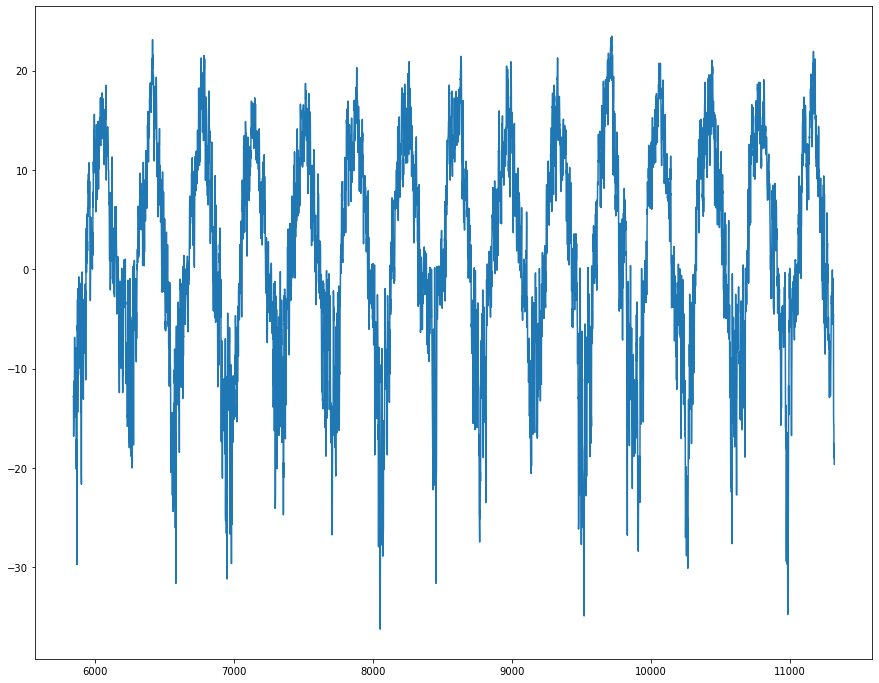

In [87]:
train_data.TMIN.plot()

## Utils

In [88]:
def train_prophet(train, name):
    train_ds = train[['DATE', f'{name}']].copy()
    train_ds.reset_index(drop=True)
    train_ds = train_ds.rename(columns={"DATE": "ds", f"{name}": "y"})

    model = Prophet(interval_width=0.85)
    with suppress_stdout_stderr():
        model.fit(train_ds)
    future = model.make_future_dataframe(periods=1826, include_history=False)
    forecast = model.predict(future)

    return forecast.yhat_lower.to_numpy(), forecast.yhat.to_numpy(), forecast.yhat_upper.to_numpy()

In [89]:
def visulize(df, name):
    plt.title(f"{name} prediction")
    df[f'{name}'].plot()
    df[f'{name}_MED'].plot()
    df[f'{name}_LOW'].plot()
    df[f'{name}_UP'].plot()
    plt.legend(["Ground Truth", "Yhat", "Yhat Lower", "Yhat Upper"]);

In [90]:
def metrics(df, name):
    rmse = mean_squared_error(df[f'{name}'], df[f'{name}_MED'], squared=False)
    rrmse = relative_rmse(df[f'{name}'], df[f'{name}_MED'])

    print("RMSE:\t%.4f" % rmse)
    print("Relative RMSE:\t%.4f" % rrmse)

## IRRAD

In [115]:
train_data.shape

(5479, 9)

In [114]:
year = 365
for i in range(1, 15):
    irrad_low, irrad_med, irrad_up = train_prophet(train_data[:i * year], "IRRAD")
    test_data['IRRAD_LOW'], test_data['IRRAD_MED'], test_data['IRRAD_UP'] = irrad_low, irrad_med, irrad_up
    print(i, " year:")
    metrics(test_data, 'IRRAD')

(365, 9)
1  year:
RMSE:	128554.4778
Relative RMSE:	1.1233
(730, 9)
2  year:
RMSE:	144409.9842
Relative RMSE:	1.1268
(1095, 9)
3  year:
RMSE:	4383.4589
Relative RMSE:	0.5153
(1460, 9)
4  year:
RMSE:	4269.1770
Relative RMSE:	0.5042
(1825, 9)
5  year:
RMSE:	4497.8055
Relative RMSE:	0.5233
(2190, 9)
6  year:
RMSE:	4850.9259
Relative RMSE:	0.5533
(2555, 9)
7  year:
RMSE:	4182.2074
Relative RMSE:	0.4936
(2920, 9)
8  year:
RMSE:	4134.9219
Relative RMSE:	0.4890
(3285, 9)
9  year:
RMSE:	4154.9399
Relative RMSE:	0.4905
(3650, 9)
10  year:
RMSE:	4095.8114
Relative RMSE:	0.4842
(4015, 9)
11  year:
RMSE:	4063.5181
Relative RMSE:	0.4807
(4380, 9)
12  year:
RMSE:	4068.4021
Relative RMSE:	0.4810
(4745, 9)
13  year:
RMSE:	4103.1413
Relative RMSE:	0.4840
(5110, 9)
14  year:
RMSE:	4044.5430
Relative RMSE:	0.4786
(5475, 9)
15  year:
RMSE:	4060.4880
Relative RMSE:	0.4797
(5479, 9)
16  year:
RMSE:	4076.1365
Relative RMSE:	0.4816
(5479, 9)
17  year:
RMSE:	4076.1365
Relative RMSE:	0.4816
(5479, 9)
18  year:
R

In [112]:
metrics(test_data, 'IRRAD')

RMSE:	4076.1365
Relative RMSE:	0.4816


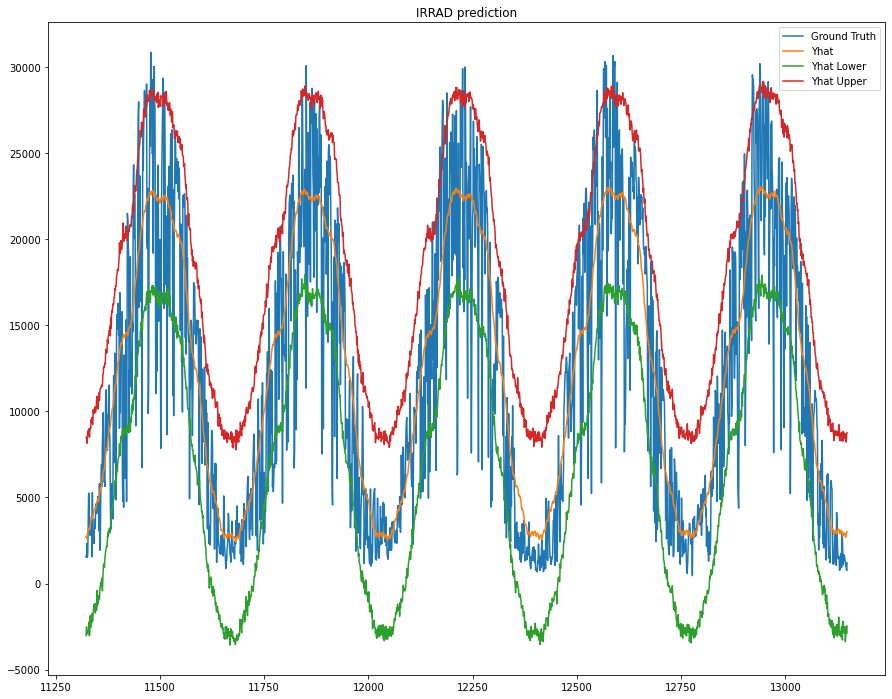

In [93]:
visulize(test_data, 'IRRAD')

## TMIN

In [94]:
tmin_low, tmin_med, tmin_up = train_prophet(train_data, "TMIN")
test_data['TMIN_LOW'], test_data['TMIN_MED'], test_data['TMIN_UP'] = tmin_low, tmin_med, tmin_up

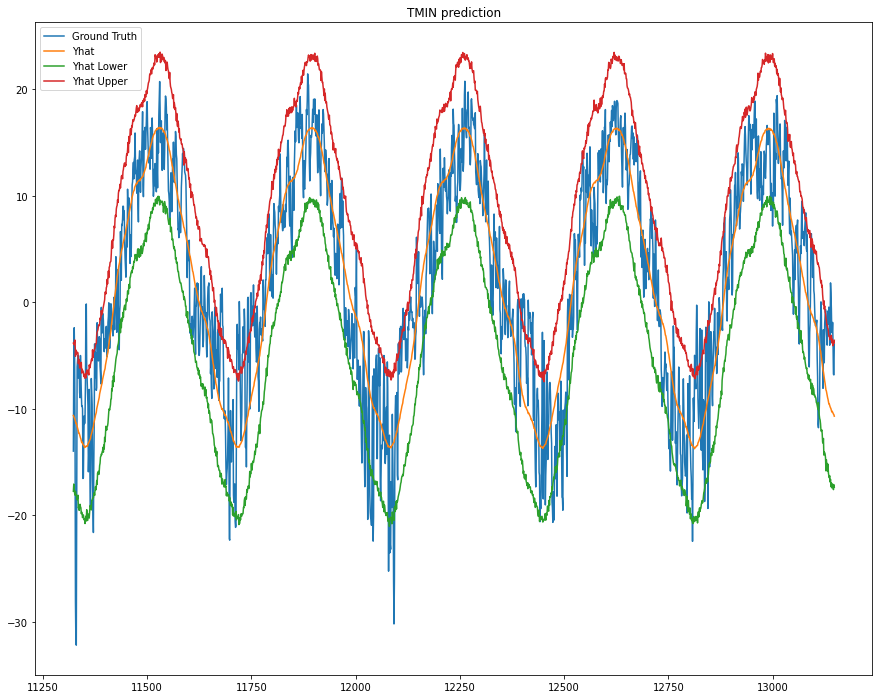

In [95]:
visulize(test_data, 'TMIN')

In [96]:
metrics(test_data, 'TMIN')

RMSE:	4.4604
Relative RMSE:	0.4326


## TMAX

In [97]:
tmax_low, tmax_med, tmax_up = train_prophet(train_data, "TMAX")
test_data['TMAX_LOW'], test_data['TMAX_MED'], test_data['TMAX_UP'] = tmax_low, tmax_med, tmax_up

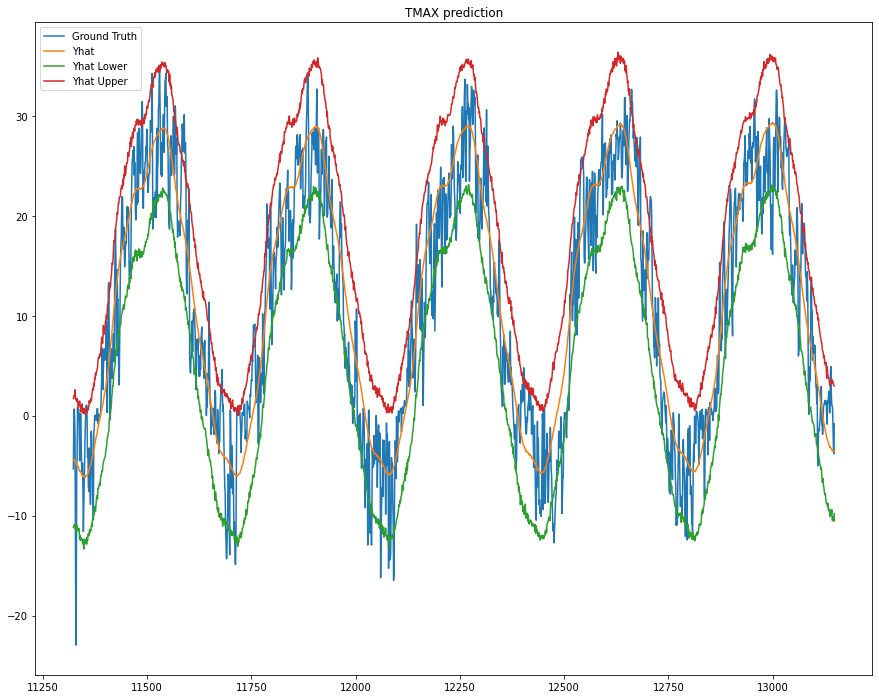

In [98]:
visulize(test_data, 'TMAX')

In [99]:
metrics(test_data, 'TMAX')

RMSE:	4.4053
Relative RMSE:	0.3568


## VAP

In [100]:
vap_low, vap_med, vap_up = train_prophet(train_data, "VAP")
test_data['VAP_LOW'], test_data['VAP_MED'], test_data['VAP_UP'] = vap_low, vap_med, vap_up

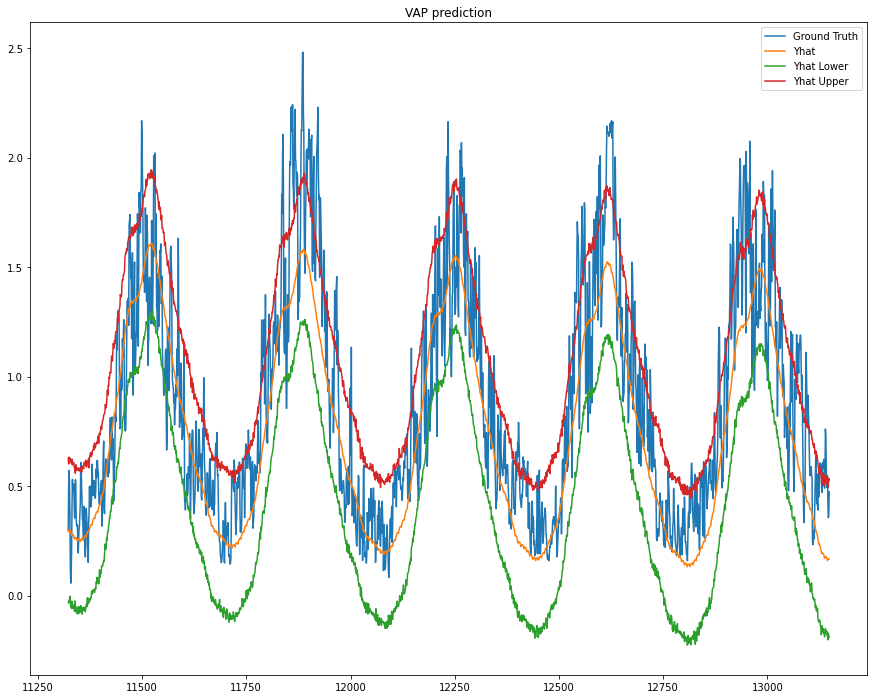

In [101]:
visulize(test_data, 'VAP')

In [102]:
metrics(test_data, 'VAP')

RMSE:	0.2809
Relative RMSE:	0.5206


## WIND

In [103]:
wind_low, wind_med, wind_up = train_prophet(train_data, "WIND")
test_data['WIND_LOW'], test_data['WIND_MED'], test_data['WIND_UP'] = wind_low, wind_med, wind_up

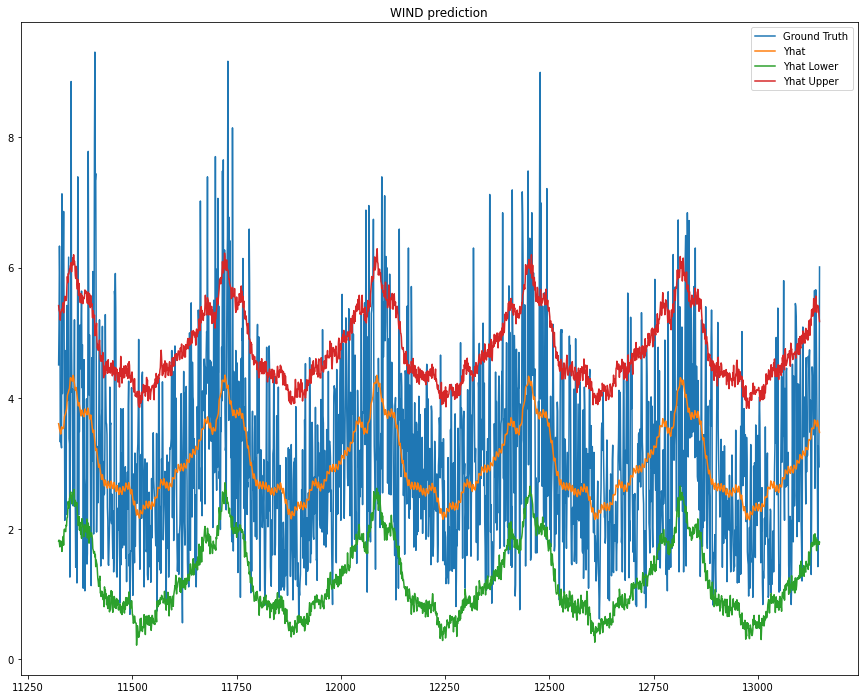

In [104]:
visulize(test_data, 'WIND')

In [105]:
metrics(test_data, 'WIND')

RMSE:	1.2714
Relative RMSE:	0.9122


## RAIN

In [106]:
rain_low, rain_med, rain_up = train_prophet(train_data, "RAIN")
test_data['RAIN_LOW'], test_data['RAIN_MED'], test_data['RAIN_UP'] = rain_low, rain_med, rain_up 

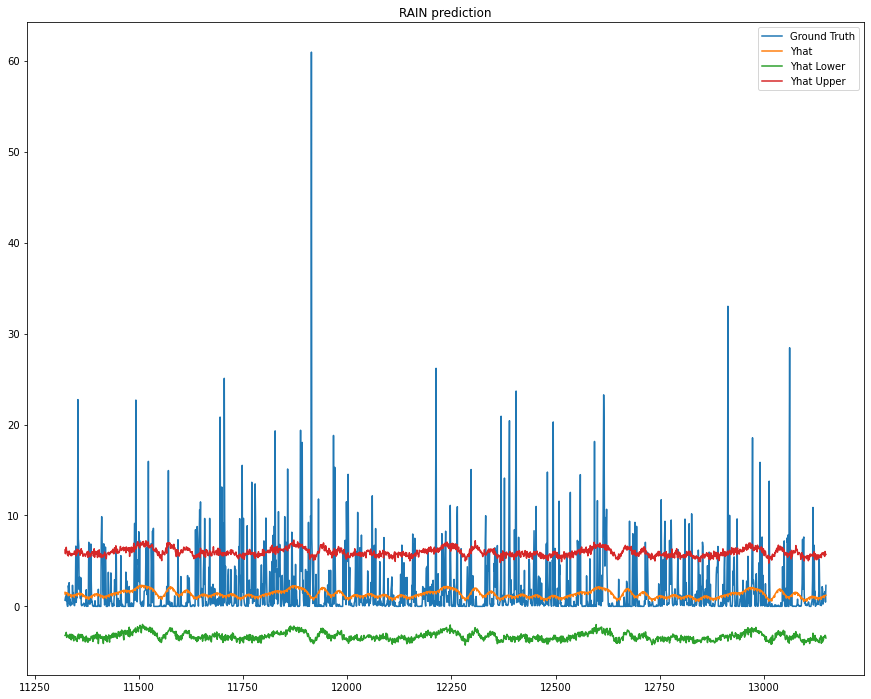

In [107]:
visulize(test_data, 'RAIN')

In [108]:
metrics(test_data, 'RAIN')

RMSE:	3.7642
Relative RMSE:	1.0027
